# Bidirectional Quadratic Voting

## Experiments

### Simulator

In [25]:
import numpy as np
from scipy import stats

def generate_candidate_preferences(num_candidates, num_issues, ideology_range):
    candidate_preferences = np.zeros((num_candidates, num_issues))
    for i, ideology in enumerate(ideology_range):
        base = np.random.normal(2.5 + ideology, 0.5, num_issues)
        candidate_preferences[i] = np.clip(base, 0, 5)

    # Set high technology preference for candidate 2
    candidate_preferences[1, -1] = np.random.uniform(4.5, 5.0)

    return candidate_preferences

def generate_voter_preferences(num_voters, num_issues, ideology_distribution):
    if ideology_distribution == 'normal':
        voter_ideologies = np.random.normal(0, 0.3, num_voters)
    elif ideology_distribution == 'bimodal':
        voter_ideologies = np.concatenate([
            np.random.normal(-0.6, 0.2, num_voters // 2),
            np.random.normal(0.6, 0.2, num_voters // 2)
        ])
    elif ideology_distribution == 'skewed_left':
        voter_ideologies = stats.skewnorm.rvs(5, loc=-0.5, scale=0.4, size=num_voters)
    elif ideology_distribution == 'skewed_right':
        voter_ideologies = -stats.skewnorm.rvs(5, loc=-0.5, scale=0.4, size=num_voters)

    voter_ideologies = np.clip(voter_ideologies, -1, 1)

    voter_preferences = np.zeros((num_voters, num_issues))
    for i, ideology in enumerate(voter_ideologies):
        base = np.random.normal(2.5 + ideology, 1.0, num_issues)
        voter_preferences[i] = np.clip(base, 0, 5)
    return voter_preferences, voter_ideologies

def calculate_normal_voting_matching_scores(distribution):
    specified_distribution = np.array(distribution)
    return specified_distribution / np.sum(specified_distribution)  # Normalize

def quadratic_voting(preferences, credits):
    votes = np.floor(np.sqrt(np.abs(preferences - 2.5) * 2)) * np.sign(preferences - 2.5)
    while np.sum(votes**2) > credits:
        max_index = np.argmax(np.abs(votes))
        votes[max_index] -= np.sign(votes[max_index])
    return votes

def calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_scores = [np.dot(voter_votes, candidate) for candidate in candidate_preferences]
        matching_scores += np.array(candidate_scores)**2  # Quadratic scoring
    return matching_scores / np.sum(matching_scores)  # Normalize

def calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_scores = [np.dot(voter_votes, quadratic_voting(candidate, 100)) for candidate in candidate_preferences]
        best_match = np.argmax(candidate_scores)
        matching_scores[best_match] += 1
    return matching_scores / np.sum(matching_scores)

### Prerequisites

In [26]:
import numpy as np

np.random.seed(42)

# Setting up issues
issues = ['Environmental Protection', 'Economic Growth', 'Education Reform', 'Social Security', 'Foreign Policy', 'Technology']
num_issues = len(issues)

# Setting up candidates
num_candidates = 5
candidates = [f'Candidate{i+1}' for i in range(num_candidates)]

# Setting up number of voters
num_voters = 10000

# Setting up ideology axis (-1: Far Left, 0: Center, 1: Far Right)
ideology_range = np.linspace(-1, 1, num_candidates)

# Generate candidate preferences (fixed)
candidate_preferences = generate_candidate_preferences(num_candidates, num_issues, ideology_range)

# Voter distribution patterns
voter_distributions = ['normal', 'bimodal', 'skewed_left', 'skewed_right']

# Tokyo Governor Election 2024 Results (Voting on July 7)
# https://www.nhk.or.jp/senkyo/database/local/shutoken/20336/skh54664.html
distribution = [0.188, 0.023, 0.243, 0.428, 0.039]


### Simulation

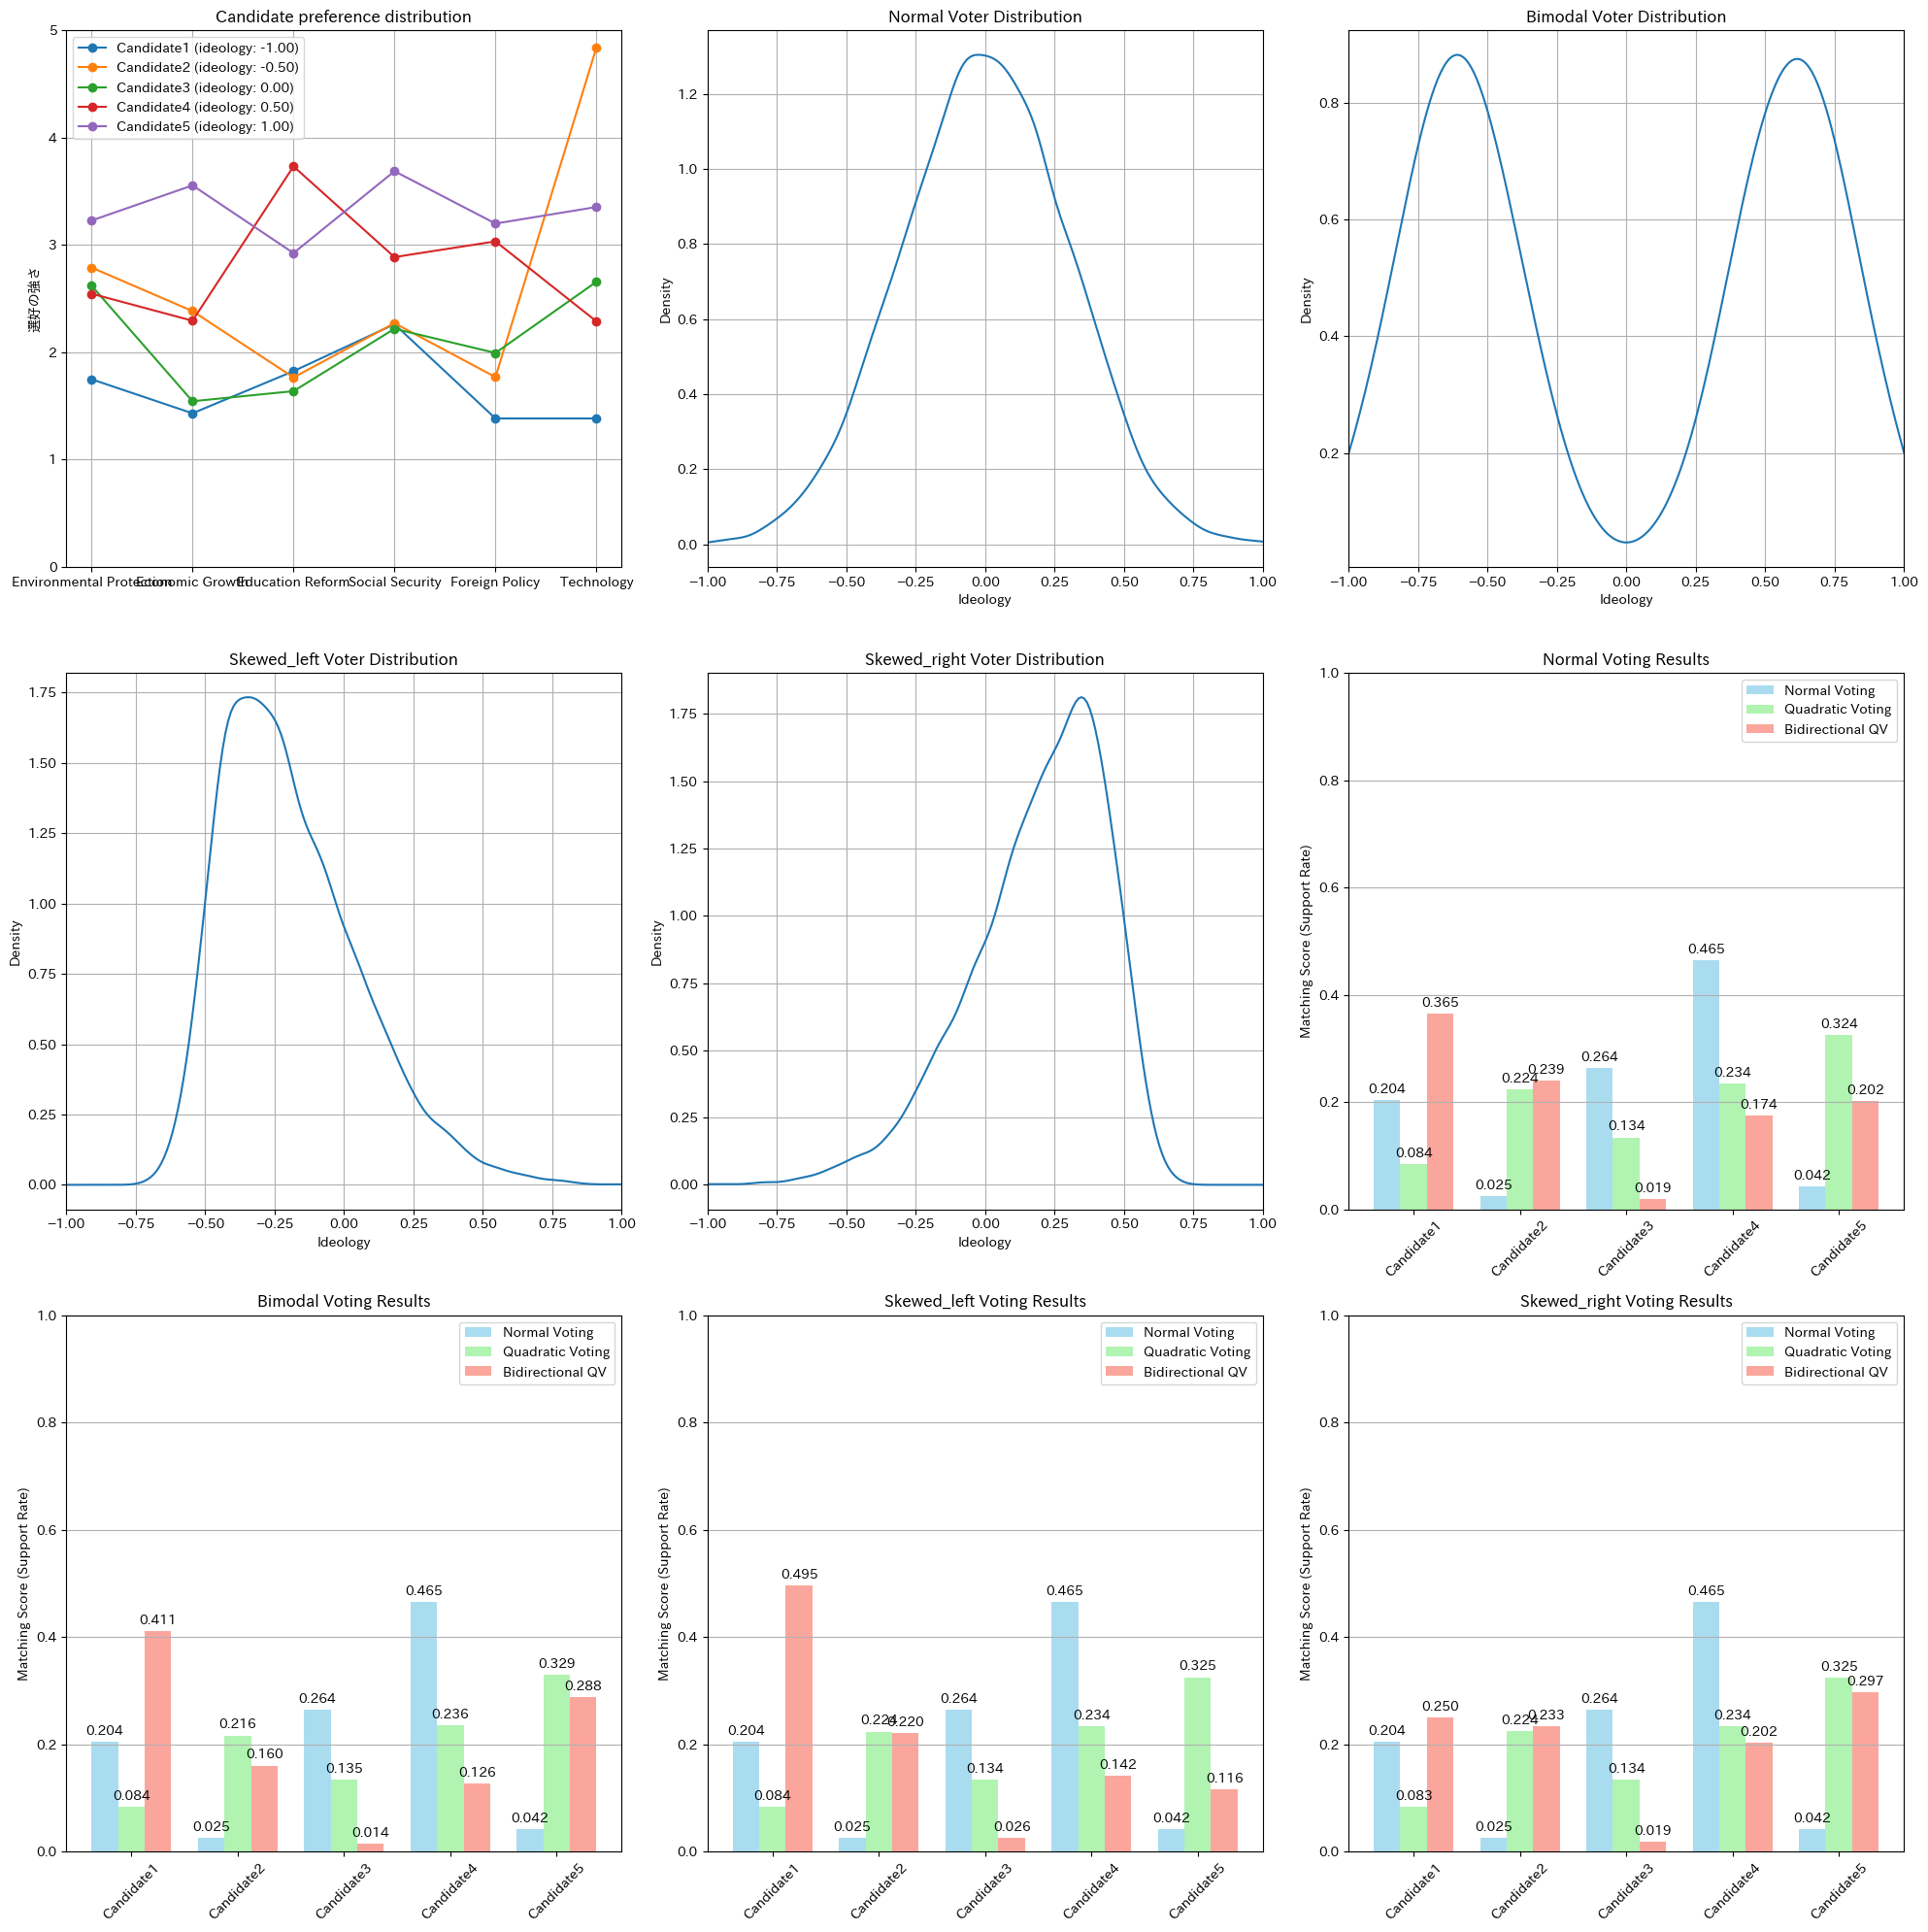

Candidate preferences:
Candidate1 (Ideology: -1.00): [1.74835708 1.43086785 1.82384427 2.26151493 1.38292331 1.38293152]
Candidate2 (Ideology: -0.50): [2.78960641 2.38371736 1.76526281 2.27128002 1.76829115 4.84211651]
Candidate3 (Ideology: 0.00): [2.62098114 1.54335988 1.63754108 2.21885624 1.99358444 2.65712367]
Candidate4 (Ideology: 0.50): [2.54598796 2.29384815 3.73282438 2.88711185 3.0337641  2.28762591]
Candidate5 (Ideology: 1.00): [3.22780864 3.55546129 2.92450321 3.68784901 3.19968066 3.35415313]

Normal Voter Distribution:
Matching scores by normal voting:
  Candidate1: 0.204
  Candidate2: 0.025
  Candidate3: 0.264
  Candidate4: 0.465
  Candidate5: 0.042
Matching scores by Quadratic Voting:
  Candidate1: 0.084
  Candidate2: 0.224
  Candidate3: 0.134
  Candidate4: 0.234
  Candidate5: 0.324
Matching scores by Bidirectional Quadratic Voting:
  Candidate1: 0.365
  Candidate2: 0.239
  Candidate3: 0.019
  Candidate4: 0.174
  Candidate5: 0.202

Bimodal Voter Distribution:
Matching sc

In [28]:
import japanize_matplotlib
import matplotlib.pyplot as plt

results = {}
for v_dist in voter_distributions:
    voter_preferences, voter_ideologies = generate_voter_preferences(num_voters, num_issues, v_dist)
    normal_scores = calculate_normal_voting_matching_scores(distribution)
    quadratic_scores = calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    bidirectional_scores = calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    results[v_dist] = (voter_ideologies, normal_scores, quadratic_scores, bidirectional_scores)

# Visualization of results
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Candidate preference distribution
axes[0, 0].set_title('Candidate preference distribution')
for i, prefs in enumerate(candidate_preferences):
    axes[0, 0].plot(issues, prefs, marker='o', label=f'{candidates[i]} (ideology: {ideology_range[i]:.2f})')
axes[0, 0].set_ylabel('選好の強さ')
axes[0, 0].set_ylim(0, 5)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Voter ideology distribution and comparison of voting methods
voter_dist_positions = [(0, 1), (0, 2), (1, 0), (1, 1)]
voting_result_positions = [(1, 2), (2, 0), (2, 1), (2, 2)]

for i, (v_dist, (voter_ideologies, normal_scores, quadratic_scores, bidirectional_scores)) in enumerate(results.items()):
    # Voter ideology distribution
    row, col = voter_dist_positions[i]
    ax_hist = axes[row, col]
    kde = stats.gaussian_kde(voter_ideologies)
    x_range = np.linspace(-1, 1, 200)
    ax_hist.plot(x_range, kde(x_range))
    ax_hist.set_title(f'{v_dist.capitalize()} Voter Distribution')
    ax_hist.set_xlabel('Ideology')
    ax_hist.set_ylabel('Density')
    ax_hist.set_xlim(-1, 1)
    ax_hist.grid(True)

    # Comparison of voting methods
    row, col = voting_result_positions[i]
    ax_match = axes[row, col]
    x = np.arange(len(candidates))
    width = 0.25

    rects1 = ax_match.bar(x - width, normal_scores, width, label='Normal Voting', color='skyblue', alpha=0.7)
    rects2 = ax_match.bar(x, quadratic_scores, width, label='Quadratic Voting', color='lightgreen', alpha=0.7)
    rects3 = ax_match.bar(x + width, bidirectional_scores, width, label='Bidirectional QV', color='salmon', alpha=0.7)

    ax_match.set_ylabel('Matching Score (Support Rate)')
    ax_match.set_title(f'{v_dist.capitalize()} Voting Results')
    ax_match.set_xticks(x)
    ax_match.set_xticklabels(candidates, rotation=45)
    ax_match.set_ylim(0, 1)
    ax_match.legend()
    ax_match.grid(axis='y')

    # Display numerical values on bar graphs
    def autolabel(rects, scores):
        for rect, score in zip(rects, scores):
            height = rect.get_height()
            ax_match.annotate(f'{score:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, normal_scores)
    autolabel(rects2, quadratic_scores)
    autolabel(rects3, bidirectional_scores)

plt.tight_layout()
plt.show()

# Output of results
print("Candidate preferences:")
for i, prefs in enumerate(candidate_preferences):
    print(f"{candidates[i]} (Ideology: {ideology_range[i]:.2f}): {prefs}")

for v_dist, (_, normal_scores, quadratic_scores, bidirectional_scores) in results.items():
    print(f"\n{v_dist.capitalize()} Voter Distribution:")
    print("Matching scores by normal voting:")
    for i, score in enumerate(normal_scores):
        print(f"  {candidates[i]}: {score:.3f}")
    print("Matching scores by Quadratic Voting:")
    for i, score in enumerate(quadratic_scores):
        print(f"  {candidates[i]}: {score:.3f}")
    print("Matching scores by Bidirectional Quadratic Voting:")
    for i, score in enumerate(bidirectional_scores):
        print(f"  {candidates[i]}: {score:.3f}")